# Initial Project Analysis Pipeline
## July 2023


Brief thoughts on pipeline here:
- Gather all data
- Identify first base recieves that are outs and that are not outs, and those that are just bad throws, but not recieved (like that play 203)

    - Other considerations here:
        - I might need to filter out throws that start too close to first for my method?
        - vertical angle?
        - velos?


- Build a probability model for this
- Make some calibration plots


From there, the path might diverge a little bit
- run expectancy?
- Fields Above Average?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prep Data

### Find throws to first that are just so bad the first baseman didn't catch it

- 203 in 1903_01_TeamNE_TeamA2 is the cannonical example

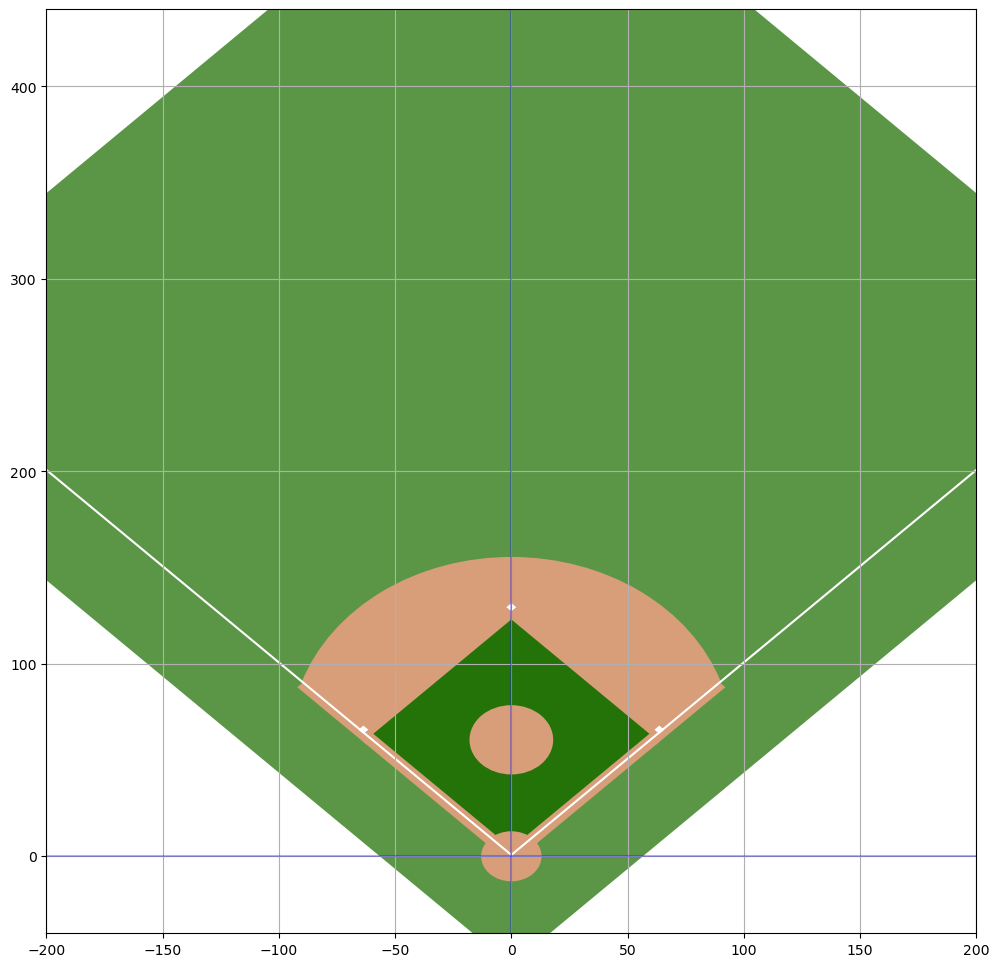

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

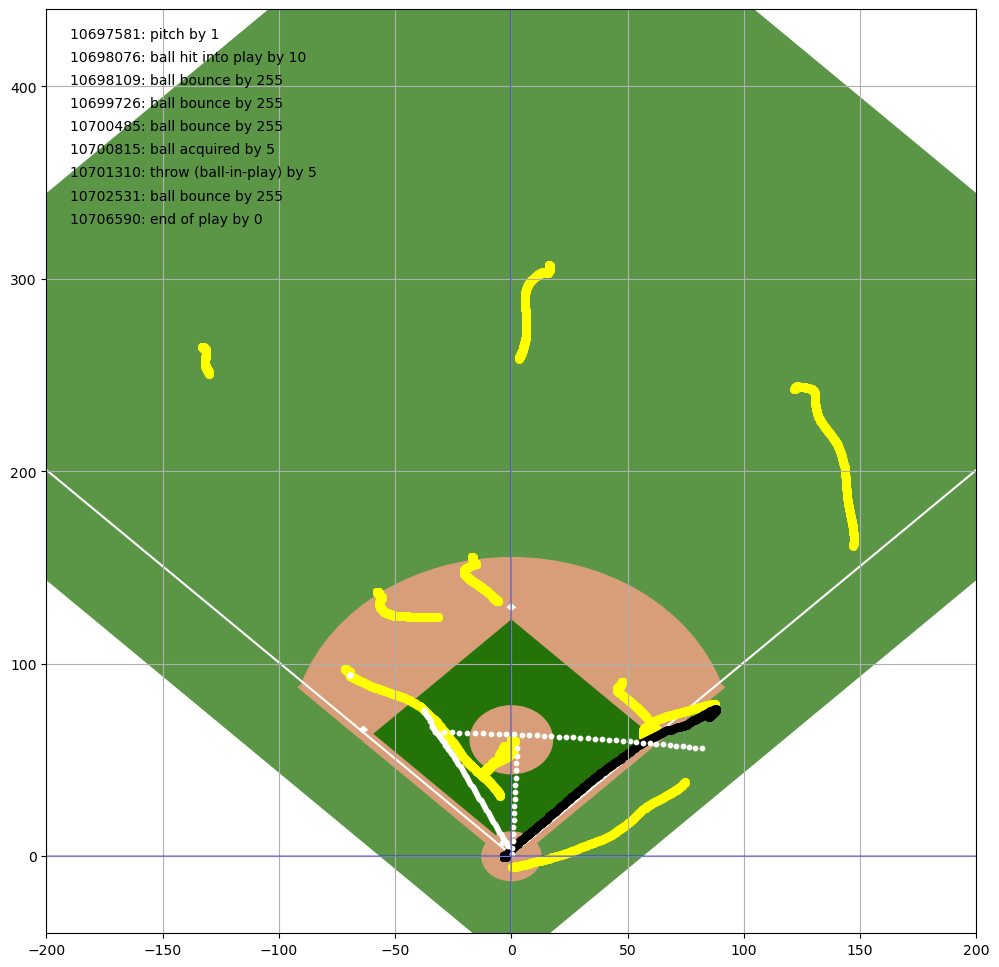

In [86]:
bf_1903_01.clear_plot()

play_id = 318 # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig
# bf_1903_01.create_gif(play_id=play_id, tag="--E5")

In [11]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()

game_events_1903_01.head(15)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
1,1903_01_TeamNE_TeamA2,1,1,1,19199,1,1,pitch,2.0,ball acquired,19661.0,NaN,NaN,NaN
2,1903_01_TeamNE_TeamA2,1,1,1,19661,2,2,ball acquired,5.0,end of play,19661.0,1.0,pitch,19199.0
3,1903_01_TeamNE_TeamA2,1,1,1,19661,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,19661.0
4,1903_01_TeamNE_TeamA2,2,1,2,29858,1,1,pitch,2.0,ball acquired,30320.0,NaN,NaN,NaN
5,1903_01_TeamNE_TeamA2,2,1,2,30320,2,2,ball acquired,5.0,end of play,30320.0,1.0,pitch,29858.0
6,1903_01_TeamNE_TeamA2,2,1,2,30320,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,30320.0
7,1903_01_TeamNE_TeamA2,3,1,3,45401,1,1,pitch,2.0,ball acquired,45929.0,NaN,NaN,NaN
8,1903_01_TeamNE_TeamA2,3,1,3,45929,2,2,ball acquired,5.0,end of play,45929.0,1.0,pitch,45401.0
9,1903_01_TeamNE_TeamA2,3,1,3,45929,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,45929.0
10,1903_01_TeamNE_TeamA2,4,1,4,58007,1,1,pitch,2.0,ball acquired,58535.0,NaN,NaN,NaN


In [25]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet

game_events_1903_01.loc[(game_events_1903_01["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1903_01["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
780,1903_01_TeamNE_TeamA2,203,51,203,6592872,255,16,ball bounce,5.0,end of play,6595314.0,3.0,throw (ball-in-play),6591420.0
1225,1903_01_TeamNE_TeamA2,318,81,319,10702531,255,16,ball bounce,5.0,end of play,10706590.0,3.0,throw (ball-in-play),10701310.0


In [28]:
throws = game_events_1903_01.loc[game_events_1903_01["event"] == "throw (ball-in-play)", :]
throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
33,1903_01_TeamNE_TeamA2,10,2,10,179315,6,3,throw (ball-in-play),2.0,ball acquired,179942.0,2.0,ball acquired,178820.0
35,1903_01_TeamNE_TeamA2,10,2,10,180536,4,3,throw (ball-in-play),2.0,ball acquired,181361.0,2.0,ball acquired,179942.0
66,1903_01_TeamNE_TeamA2,18,4,18,461301,6,3,throw (ball-in-play),2.0,ball acquired,462225.0,2.0,ball acquired,460212.0
96,1903_01_TeamNE_TeamA2,25,6,25,616962,7,3,throw (ball-in-play),2.0,ball acquired,618777.0,2.0,ball acquired,615543.0
110,1903_01_TeamNE_TeamA2,28,7,28,714180,6,3,throw (ball-in-play),2.0,ball acquired,714840.0,2.0,ball acquired,713652.0
138,1903_01_TeamNE_TeamA2,36,8,36,1016790,9,3,throw (ball-in-play),16.0,ball bounce,1018407.0,2.0,ball acquired,1013886.0
150,1903_01_TeamNE_TeamA2,38,9,38,1094175,5,3,throw (ball-in-play),2.0,ball acquired,1095198.0,2.0,ball acquired,1092459.0
216,1903_01_TeamNE_TeamA2,58,13,58,1618117,6,3,throw (ball-in-play),2.0,ball acquired,1619239.0,2.0,ball acquired,1616896.0
256,1903_01_TeamNE_TeamA2,69,16,69,2010520,8,3,throw (ball-in-play),2.0,ball acquired,2012434.0,2.0,ball acquired,2009662.0
273,1903_01_TeamNE_TeamA2,73,17,73,2191492,5,3,throw (ball-in-play),2.0,ball acquired,2192317.0,2.0,ball acquired,2190634.0


In [32]:
ball_pos_1903_01 = bf_1903_01.game_obj.new_ball_pos.copy()
ball_pos_1903_01

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z,smoothed_ball_position_x,smoothed_ball_position_y,smoothed_ball_position_z,lag_1_timestamp,lag_1_ball_position_x,lag_1_ball_position_y,lag_1_ball_position_z,lag_1_smoothed_ball_position_x,lag_1_smoothed_ball_position_y,lag_1_smoothed_ball_position_z,diff_timestamp,diff_ball_position_x,diff_ball_position_y,diff_ball_position_z,diff_smoothed_ball_position_x,diff_smoothed_ball_position_y,diff_smoothed_ball_position_z,ball_velo_x,ball_velo_y,ball_velo_z,smoothed_ball_velo_x,smoothed_ball_velo_y,smoothed_ball_velo_z
1,1903_01_TeamNE_TeamA2,1,19199,-2.387367,54.2868,6.37134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1903_01_TeamNE_TeamA2,1,19232,-2.274918,49.9272,6.29283,-2.279390,49.936900,6.286760,19199.0,-2.387367,54.2868,6.37134,NaN,NaN,NaN,33.0,0.112449,-4.3596,-0.07851,NaN,NaN,NaN,3.407545,-132.109091,-2.379091,NaN,NaN,NaN
3,1903_01_TeamNE_TeamA2,1,19265,-2.175885,45.5967,6.19611,-2.232110,47.776425,6.235365,19232.0,-2.274918,49.9272,6.29283,-2.279390,49.936900,6.286760,33.0,0.099033,-4.3305,-0.09672,0.047280,-2.160475,-0.051395,3.001000,-131.227273,-2.930909,1.432720,-65.468939,-1.557424
4,1903_01_TeamNE_TeamA2,1,19298,-2.090271,41.2950,6.08118,-2.139787,43.460250,6.129532,19265.0,-2.175885,45.5967,6.19611,-2.232110,47.776425,6.235365,33.0,0.085614,-4.3017,-0.11493,0.092324,-4.316175,-0.105832,2.594364,-130.354545,-3.482727,2.797682,-130.793182,-3.207045
5,1903_01_TeamNE_TeamA2,1,19331,-2.018073,37.0221,5.94801,-2.060881,39.173025,6.005475,19298.0,-2.090271,41.2950,6.08118,-2.139787,43.460250,6.129532,33.0,0.072198,-4.2729,-0.13317,0.078906,-4.287225,-0.124058,2.187818,-129.481818,-4.035455,2.391091,-129.915909,-3.759318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14254,1903_01_TeamNE_TeamA2,326,10933564,49.362600,71.1342,5.61570,47.812650,71.612175,5.771228,10933531.0,46.281600,72.0924,5.95746,44.722200,72.569400,6.097643,33.0,3.081000,-0.9582,-0.34176,3.090450,-0.957225,-0.326415,93.363636,-29.036364,-10.356364,93.650000,-29.006818,-9.891364
14255,1903_01_TeamNE_TeamA2,326,10933597,52.424700,70.1736,5.24322,50.884275,70.652850,5.414100,10933564.0,49.362600,71.1342,5.61570,47.812650,71.612175,5.771228,33.0,3.062100,-0.9606,-0.37248,3.071625,-0.959325,-0.357127,92.790909,-29.109091,-11.287273,93.079545,-29.070455,-10.822045
14256,1903_01_TeamNE_TeamA2,326,10933630,55.468200,69.2112,4.84002,53.937000,69.691425,5.026268,10933597.0,52.424700,70.1736,5.24322,50.884275,70.652850,5.414100,33.0,3.043500,-0.9624,-0.40320,3.052725,-0.961425,-0.387833,92.227273,-29.163636,-12.218182,92.506818,-29.134091,-11.752500
14257,1903_01_TeamNE_TeamA2,326,10933663,58.492500,68.2467,4.40613,56.970825,68.727825,4.607715,10933630.0,55.468200,69.2112,4.84002,53.937000,69.691425,5.026268,33.0,3.024300,-0.9645,-0.43389,3.033825,-0.963600,-0.418553,91.645455,-29.227273,-13.148182,91.934091,-29.200000,-12.683409


In [178]:
def compute_throw_angle(a, target_point = np.array([63.63961031, 63.63961031])):
    """
    
    target_point defaults to first base
    
    """
    
    # TODO: do I NEED THE angle of inclination even here?
    # I think not for now!
        
    # make a vector from the first point to the target point
    xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

    # scale it to be a unit vector
    unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))
    
    # Maybe the whole window so we don't get noise?
    throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
        - a[["ball_position_x", "ball_position_y"]].iloc[0].values
    
    # the other one is a unit vect, so we don't need to divide here
    xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))
    
    xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

    # hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 

    return xy_angle_to_first_deg
    
    

In [171]:
def fill_throw_angle(timestamp, ball_pos_df, target_point = np.array([63.63961031, 63.63961031])): 
    """
    
    """
    
    ball_pos_df = ball_pos_df.copy()
    
    # print(timestamp)

    buffer_ms = -10
    snapshot_time = 250

    # find when the ball is in the air with a buffer or not
    ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                       (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                       # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                       :
                                      ] 
    
    # print(ball_in_air_df["play_id"].describe())
    angle = compute_throw_angle(ball_in_air_df, target_point)
    
    return angle
    
    
    

In [175]:
throws["xy_throw_angle"] = np.nan
throws["xy_throw_angle"] = throws.apply(lambda row: fill_throw_angle(row["timestamp"], ball_pos_1903_01), axis = 1)

<Axes: ylabel='Frequency'>

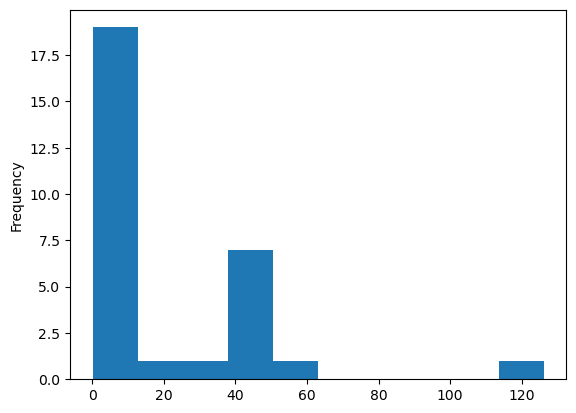

In [210]:
throws["xy_throw_angle"].loc[(throws["player_position"].isin([1, 2, 4, 5, 6]))].plot(kind="hist")

In [213]:
# because this is like the cosine similarity to each other, we don't have a sense for which side of the bag the throw went to
# want infielder throws only
# note that higher angles throws are either throws behind a runner (usually in the [5, 10] range)
# or they are bad throws?

throws.loc[(throws["xy_throw_angle"] > 100) & (throws["player_position"].isin([1, 2, 4, 5, 6]) ), :]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle
482,1903_01_TeamNE_TeamA2,124,32,124,3912774,4,3,throw (ball-in-play),2.0,ball acquired,3913302.0,2.0,ball acquired,3912312.0,126.131484


In [215]:
# look at all of these with the outs

In [217]:
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()

In [221]:
game_info_1903_01.loc[game_info_1903_01["play_per_game"] == 124]

game_info_1903_01.loc[(game_info_1903_01["inning"] == 4) & (game_info_1903_01["top_bottom_inning"] == "Top")]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
117,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,30,118,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,6803,0,0,0,0,0,0,1,1.0,0.0,0.0,0.0,1,1,1
118,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,30,119,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,6803,0,0,0,0,0,1,1,1.0,0.0,0.0,0.0,1,1,1
119,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,31,120,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,5616,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
120,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,31,121,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,5616,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
121,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,31,122,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,5616,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
122,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,31,123,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,5616,0,0,0,0,1,0,1,1.0,0.0,0.0,0.0,1,1,1
123,1903_01_TeamNE_TeamA2,TeamA2,TeamNE,32,124,4,Top,2171,2790,2526,2053,2382,1972,1557,1751,2973,6993,5616,0,0,1,1,2,1,1.0,1.0,0.0,0.0,1,1,1


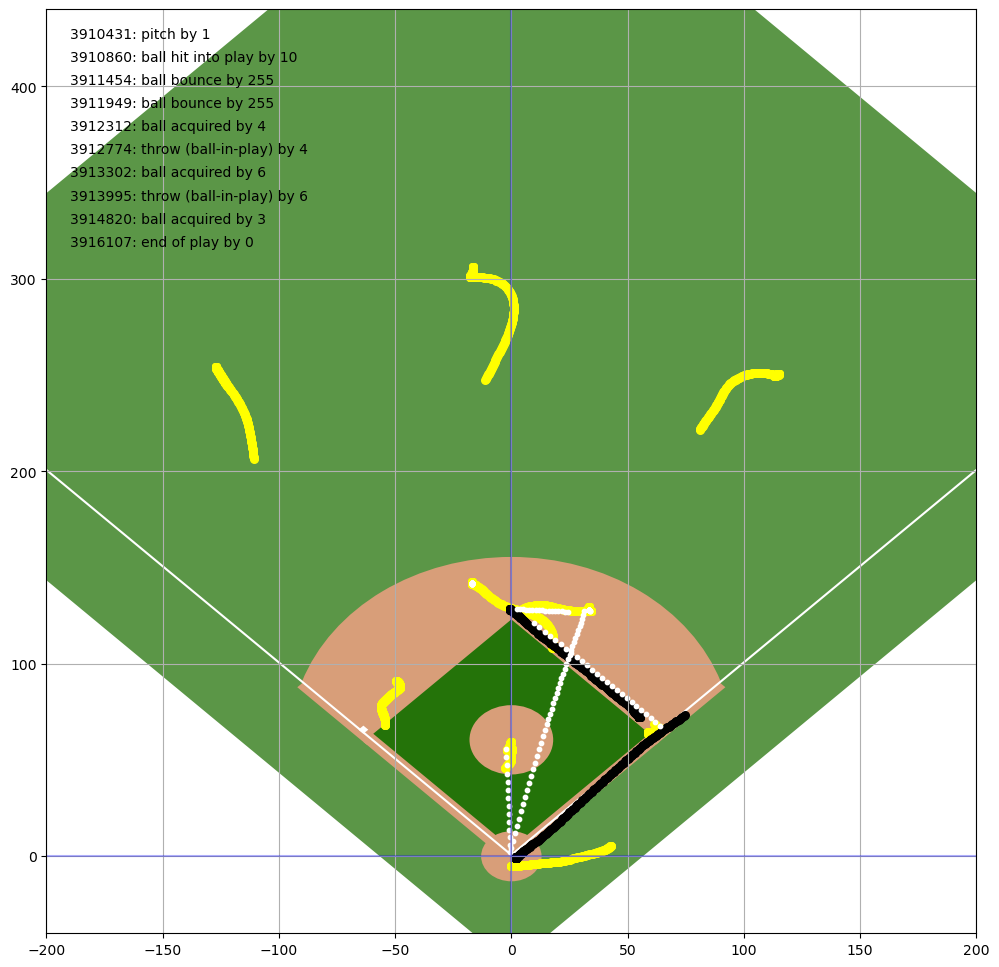

In [223]:
bf_1903_01.clear_plot()

play_id = 124 # throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--4-6-3 dp")

### Check another game

In [225]:
bf_1902_24 = Baseball_Field("1902_24_TeamMA_TeamA1")

In [229]:
game_events_1902_24 = bf_1902_24.game_obj.game_events_df.copy()

game_events_1902_24.head(15)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
1,1902_24_TeamMA_TeamA1,1,1.0,1,23257,1,1,pitch,2.0,ball acquired,23752.0,NaN,NaN,NaN
2,1902_24_TeamMA_TeamA1,1,1.0,1,23752,2,2,ball acquired,5.0,end of play,23752.0,1.0,pitch,23257.0
3,1902_24_TeamMA_TeamA1,1,1.0,1,23752,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,23752.0
4,1902_24_TeamMA_TeamA1,2,1.0,2,35731,1,1,pitch,4.0,ball hit into play,36160.0,NaN,NaN,NaN
5,1902_24_TeamMA_TeamA1,2,1.0,2,36160,10,4,ball hit into play,5.0,end of play,36490.0,1.0,pitch,35731.0
6,1902_24_TeamMA_TeamA1,2,1.0,2,36490,0,5,end of play,NaN,NaN,NaN,4.0,ball hit into play,36160.0
7,1902_24_TeamMA_TeamA1,3,1.0,3,53650,1,1,pitch,4.0,ball hit into play,54079.0,NaN,NaN,NaN
8,1902_24_TeamMA_TeamA1,3,1.0,3,54079,10,4,ball hit into play,16.0,ball bounce,55597.0,1.0,pitch,53650.0
9,1902_24_TeamMA_TeamA1,3,1.0,3,55597,255,16,ball bounce,16.0,ball bounce,56191.0,4.0,ball hit into play,54079.0
10,1902_24_TeamMA_TeamA1,3,1.0,3,56191,255,16,ball bounce,2.0,ball acquired,57577.0,16.0,ball bounce,55597.0


In [230]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet
# I would expect there to be not than many here!

game_events_1902_24.loc[(game_events_1902_24["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1902_24["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts


In [ ]:
## Add this method to the data collection!

In [ ]:
all_games = get_all_game_strs()

In [ ]:
total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0

total_trusted_double_plays = 0


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :].shape[0]
        
    trusted_successful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ].shape[0]
    
    trusted_unsuccessful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ].shape[0]
    
    trusted_double_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 2) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ].shape[0]
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {}\n".format(
        trusted_outs,
        trusted_successful_first_base_outs,
        trusted_unsuccessful_first_base_outs,
        trusted_double_plays
    ))
    
    # TODO: Add overthrows here!
    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs
    total_trusted_double_plays += trusted_double_plays
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {}\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_trusted_double_plays
))
